<a href="https://colab.research.google.com/github/RipeMangoBox/STARRY/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Configuration Setup

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torchvision import datasets, transforms
from typing import List, Callable, Union, Any, TypeVar, Tuple
from sklearn.manifold import TSNE
import pandas as pd




# Step 2 - VAE Model

In [11]:
class VAE(nn.Module):
  def __init__(self, config: dict = None):
    super(VAE, self).__init__()

    self.image_size = config.image_size
    self.input_dim = config.input_channel
    self.conv_dims = config.conv_dims
    self.fc_dim = config.fc_dim
    self.latent_dim = config.latent_dim

    self.beta = 1

    self.encoder = Encoder(self.image_size, self.input_dim, self.conv_dims, self.fc_dim, self.latent_dim)
    self.decoder = Decoder(self.image_size, self.input_dim, self.conv_dims, self.latent_dim)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    mu, log_var = self.encoder(x)
    z = self.reparameterize(mu, log_var)
    return self.decoder(z), mu, log_var

  def calc_loss(self, x, recon_x, mu, log_var):
    recons_loss = F.mse_loss(recon_x, x, reduction="sum").div(x.shape[0])
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    return recons_loss + self.beta * kld_loss

In [12]:
a = torch.randn(1, 2, 2, 2)
b = torch.randn_like(a)
loss = F.mse_loss(a, b)
loss2 = F.mse_loss(a, b).sum([0]).mean()
loss3 = F.mse_loss(a, b, reduction="sum").div(a.shape[0])

for item in [a, b, loss, loss2, loss3]:
  print(item)
print(((a - b)**2).mean())

tensor([[[[ 2.3248e+00,  3.1419e-01],
          [-1.2831e-01,  1.1152e+00]],

         [[ 4.5978e-01,  6.5653e-04],
          [-3.5755e-01,  2.0714e-01]]]])
tensor([[[[-0.3834, -0.6025],
          [-0.1658,  0.1093]],

         [[ 0.9647,  0.4260],
          [-0.0717,  1.7803]]]])
tensor(1.5225)
tensor(1.5225)
tensor(12.1803)
tensor(1.5225)


In [13]:
F.mse_loss(a, b), 8 * F.mse_loss(a, b), F.mse_loss(a, b, reduction="sum"), F.mse_loss(a, b, reduction="sum").div(a.shape[0])

(tensor(1.5225), tensor(12.1803), tensor(12.1803), tensor(12.1803))

In [14]:
class Encoder(nn.Module):
  def __init__(self,
         image_size: int,
         input_dim: int,
         conv_dims: List,
         fc_dim: int,
         latent_dim: int):
    super().__init__()

    conv_layers = []

    in_channels = input_dim
    for conv_dim in conv_dims:
      conv_layer = nn.Sequential(
        nn.Conv2d(in_channels, conv_dim, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(conv_dim),
        nn.LeakyReLU()
      )
      conv_layers.append(conv_layer)
      in_channels = conv_dim
    self.convs = nn.Sequential(*conv_layers)

    # fc_input_dim = latent_size^2 * feature_map_num
    fc_input_dim = (image_size // 2 ** len(conv_dims)) ** 2 * conv_dims[-1]

    self.fc = nn.Sequential(
      nn.Linear(fc_input_dim, fc_dim),
      nn.LeakyReLU()
    )

    self.mu = nn.Linear(fc_dim, latent_dim)
    self.log_var = nn.Linear(fc_dim, latent_dim)

  def forward(self, x):
    x = self.convs(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    mu, log_var = self.mu(x), self.log_var(x)

    return mu, log_var

class Decoder(nn.Module):
  def __init__(self,
         image_size: int,
         output_dim: int,
         conv_dims: List,
         latent_dim: int):
    super().__init__()

    # fc_input_dim = latent_size^2 * feature_map_num
    self.latent_size = image_size // 2 ** len(conv_dims)
    fc_input_dim = self.latent_size ** 2 * conv_dims[-1]
    self.fc = nn.Sequential(
      nn.Linear(latent_dim, fc_input_dim),
      nn.LeakyReLU()
    )

    self.latent_size = image_size // 2 ** len(conv_dims)

    deconv_layers = []

    out_channels = conv_dims[-1]
    for conv_dim in conv_dims[::-1]:
      conv_layer = nn.Sequential(
        nn.ConvTranspose2d(out_channels, conv_dim, kernel_size=3, stride=2, padding=1, output_padding=1),# p'=k-1-p, p denotes padding in Conv2d, p' denotes paddingin ConvTranspose2d
        nn.BatchNorm2d(conv_dim),
        nn.LeakyReLU()
      )
      deconv_layers.append(conv_layer)
      out_channels = conv_dim
    self.de_convs = nn.Sequential(*deconv_layers)

    self.to_rgb = nn.Sequential(
      nn.ConvTranspose2d(conv_dims[0], conv_dims[0], kernel_size=3, stride=2, padding=1, output_padding=1),
      nn.LeakyReLU(),
      nn.Conv2d(conv_dims[0], output_dim, kernel_size=3, stride=2, padding=1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.fc(x)
    # print(f"Decoder fc x:{x.shape}")
    x = x.view(x.size(0), -1, self.latent_size, self.latent_size)
    # print(f"Decoder view x:{x.shape}")
    x = self.de_convs(x)
    # print(f"Decoder de_convs x:{x.shape}")
    x = self.to_rgb(x)

    return x



# Step 3 - Training

In [15]:
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


In [16]:
MNIST_config = Config(
    image_size = 28,
    conv_dims = [32, 64],
    fc_dim = 128,
    latent_dim = 64,
    batch_size = 128,
    epochs = 10,
    input_channel = 1,

    n_cols = 8,
    n_rows = 8

)

CRIFA10_config = Config(
    image_size = 32,
    conv_dims = [32, 64],
    fc_dim = 128,
    latent_dim = 64,
    batch_size = 128,
    epochs = 15,
    input_channel = 3,

    n_cols = 14,
    n_rows = 14

)

transform=transforms.Compose([
    transforms.ToTensor()
])


In [17]:
DATASET_Opt = 'CIFAR10'

if DATASET_Opt == 'MNIST':
    dataset1 = datasets.MNIST('../data/', train=True, download=True,
                        transform=transform)
    dataset2 = datasets.MNIST('../data/', train=False,
                        transform=transform)
    args = MNIST_config

elif DATASET_Opt == 'CIFAR10':
    dataset1 = datasets.CIFAR10('../data/', train=True, download=True,
                        transform=transform)
    dataset2 = datasets.CIFAR10('../data/', train=False,
                        transform=transform)
    args = CRIFA10_config

# 超参
image_size, conv_dims, fc_dim, latent_dim, batch_size, epochs, input_channel, n_cols, n_rows = vars(args).values()

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = VAE(args).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [18]:
print_freq = 200
for epoch in range(epochs):
  print("Start training epoch {}".format(epoch,))
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    recon, mu, log_var = model(images)
    loss = model.calc_loss(images, recon, mu, log_var)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
        print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [199/391]: loss 110.97998809814453
	 [390/391]: loss 99.98939514160156
Start training epoch 1
	 [199/391]: loss 93.47196960449219
	 [390/391]: loss 94.56058502197266
Start training epoch 2
	 [199/391]: loss 94.65558624267578
	 [390/391]: loss 95.14749908447266
Start training epoch 3
	 [199/391]: loss 85.2966537475586
	 [390/391]: loss 83.07146453857422
Start training epoch 4
	 [199/391]: loss 86.25112915039062
	 [390/391]: loss 83.37376403808594
Start training epoch 5
	 [199/391]: loss 86.09326171875
	 [390/391]: loss 80.20612335205078
Start training epoch 6
	 [199/391]: loss 81.79705810546875
	 [390/391]: loss 85.93350982666016
Start training epoch 7
	 [199/391]: loss 82.05914306640625
	 [390/391]: loss 83.8968276977539
Start training epoch 8
	 [199/391]: loss 78.08563995361328
	 [390/391]: loss 84.70001220703125
Start training epoch 9
	 [199/391]: loss 78.90679931640625
	 [390/391]: loss 77.01634979248047
Start training epoch 10
	 [199/391]: loss 79.125663757

# Step 4 - Results

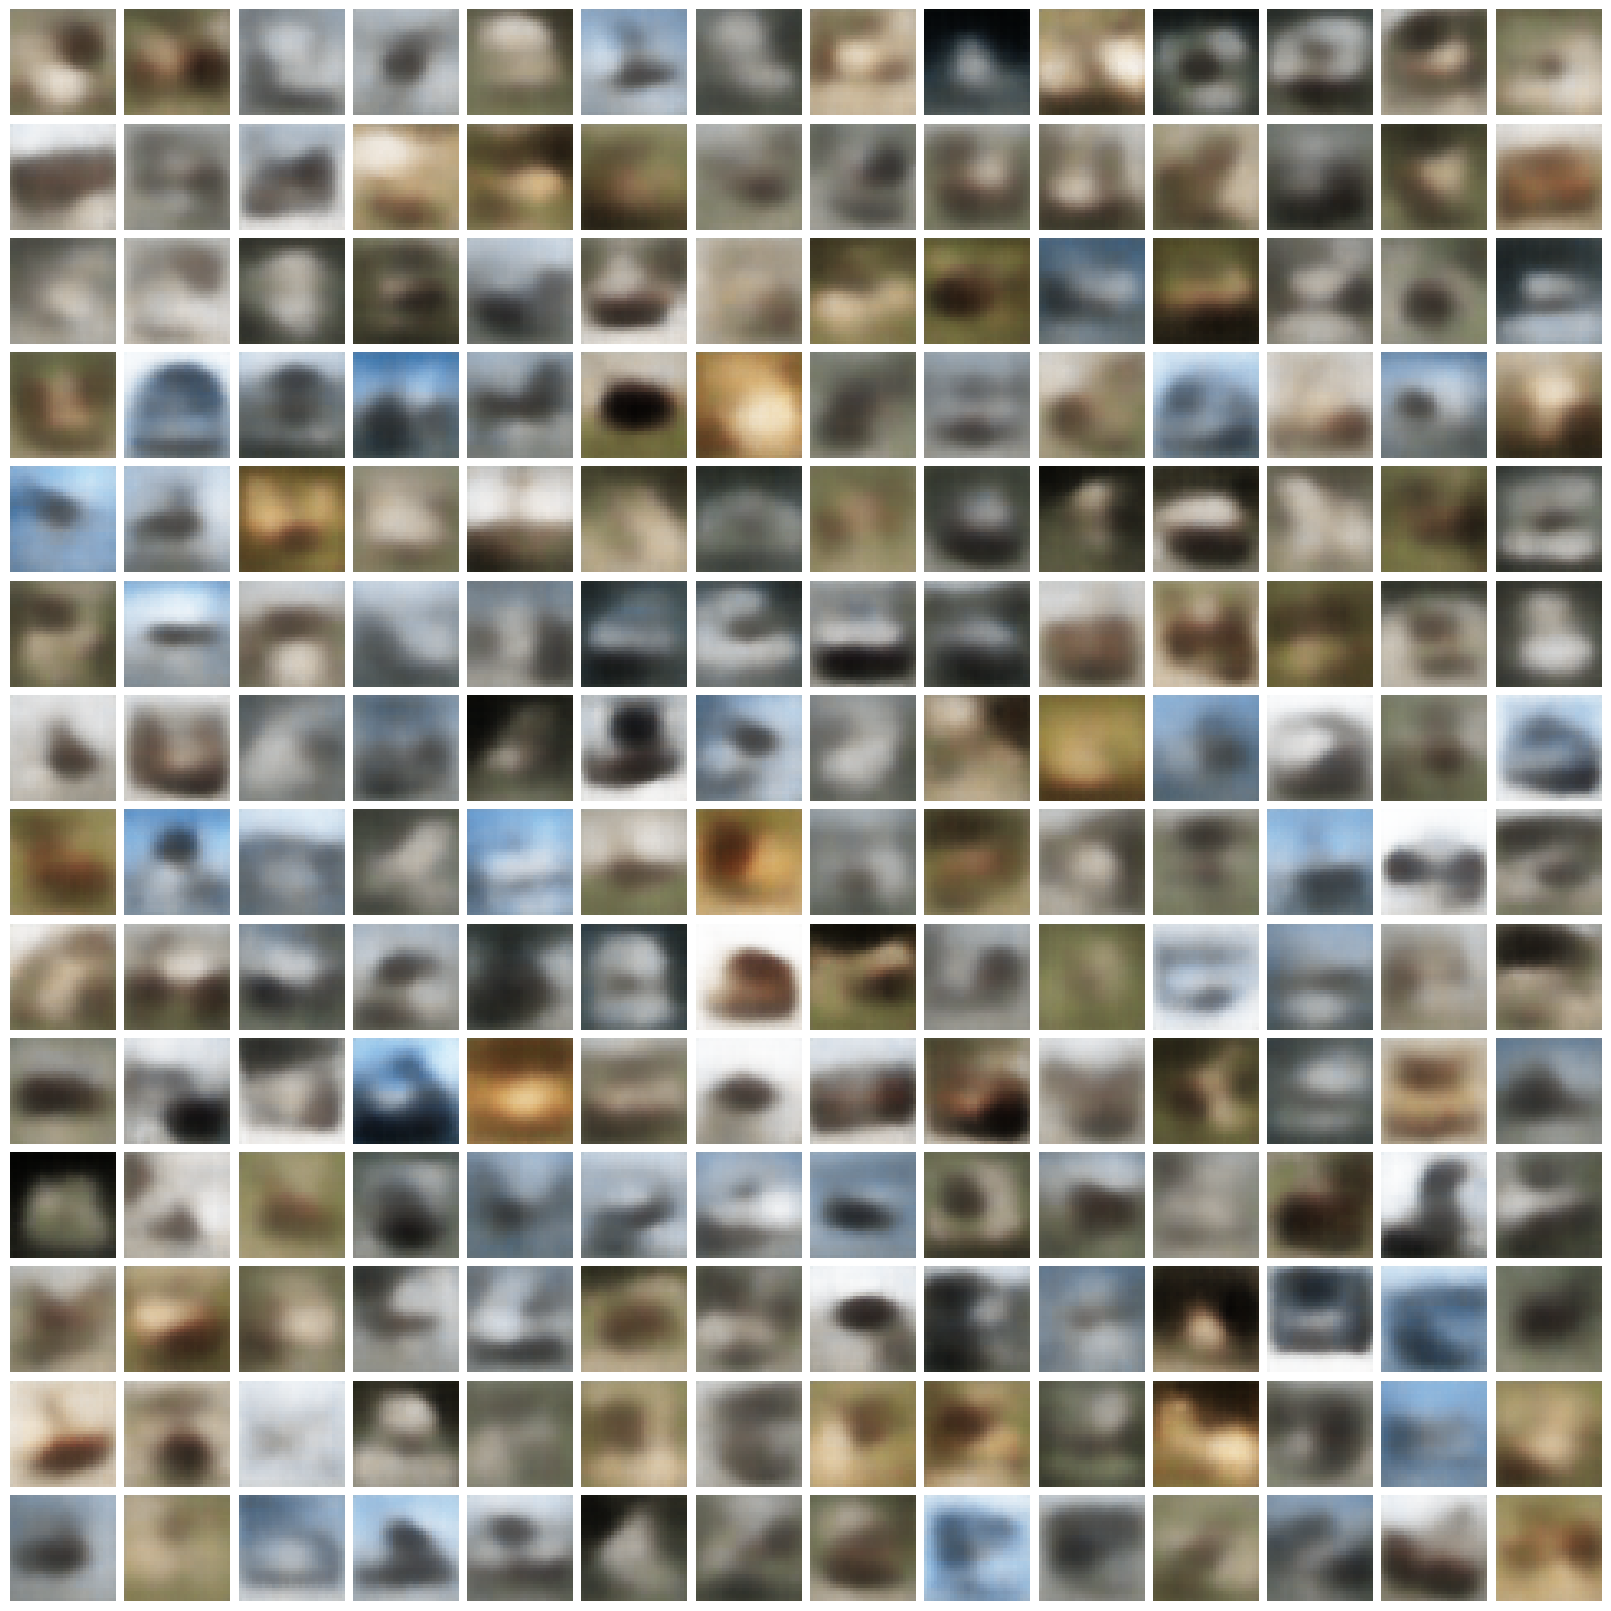

In [19]:
## generate new images by VAE

sample_zs = torch.randn(n_rows * n_cols, latent_dim)
model.eval()
with torch.no_grad():
    generated_imgs = model.decoder(sample_zs.cuda())
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, input_channel, image_size, image_size)

fig = plt.figure(figsize=(image_size//2, image_size//2), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)

for n_row in range(n_rows):
    for n_col in range(n_cols):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = generated_imgs[n_row, n_col]  # 获取图像数据
        if DATASET_Opt == 'MNIST':
            f_ax.imshow(img.squeeze(), cmap='gray')  # 对于 MNIST，去除单通道维度
        else:  # 对于 CIFAR10 或其他 RGB 图像，保留通道维度放到最后
            f_ax.imshow(img.transpose(1, 2, 0))
        f_ax.axis("off")

plt.show()

# Step 5 - Visualization

In [20]:
def plot_latent_space_tsne(variable='mu', nums=1000):
  model.eval()
  with torch.no_grad():
    latent_vectors = []
    labels = []
    for data, label in test_loader:
      data = data.to(device)
      mu, logvar = model.encoder(data)

      z = model.reparameterize(mu, logvar) if variable == 'z' else mu
      latent_vectors.append(z.cpu())
      labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0)[:nums]
    labels = torch.cat(labels, dim=0)[:nums]

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=2023)
    latent_tsne = tsne.fit_transform(latent_vectors)

    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Visualization of Latent Space {variable}')
    plt.show()

### $\mu$的可视化

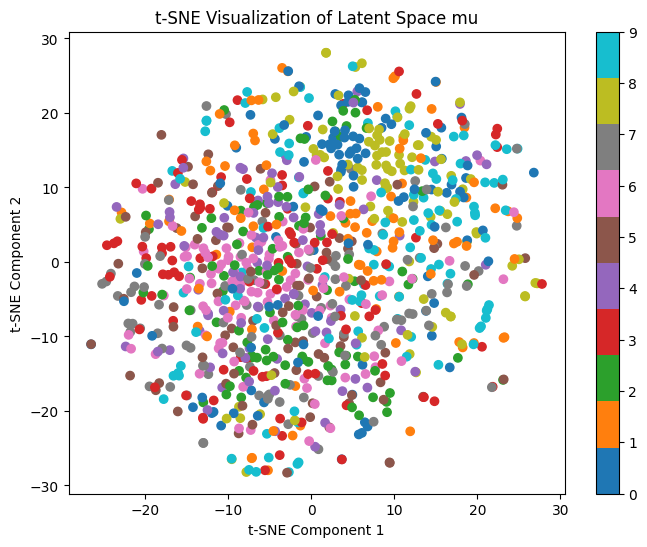

In [21]:
plot_latent_space_tsne('mu', 1000)

### z的可视化

In [22]:
# 由于方差存在，z的可视化需要远比mu多的点才能看出效果
plot_latent_space_tsne('z', None)

KeyboardInterrupt: 